In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import csv

class Struct:
    pass


In [3]:
class MyVNS:
    def shake(self, x, k, probdata):
        y = copy.deepcopy(x)
        ridx1 = np.random.randint(0, probdata.n)
        ridx2 = np.random.randint(0, probdata.n)
        blockSize = 50
        startIndex = np.random.randint(0, probdata.n - blockSize)
        blockIndices = range(startIndex, startIndex + blockSize)

        if k == 1:
            y.solution[ridx1] = np.random.choice([j for j in [0, 1, 2] if j != x.solution[ridx1]])
        elif k == 2:
            y.solution[ridx1], y.solution[ridx2] = x.solution[ridx2], x.solution[ridx1]
        elif k == 3:
            currentPlans = [x.solution[i] for i in blockIndices]
            currentPlan = max(set(currentPlans), key=currentPlans.count)
            newPlan = np.random.choice([j for j in [0, 1, 2] if j != currentPlan])
            for i in blockIndices:
                y.solution[i] = newPlan
        return y

    def neighborhoodChange(self, x, y, k):
        if y.fitness < x.fitness:
            x = copy.deepcopy(y)
            k = 1
        else:
            k += 1
        return x, k

    def bestImprovement(self, x, probdata, fobj, k):
        neighborhood_size = 100
        best_solution = copy.deepcopy(x)
        for _ in range(neighborhood_size):
            current_solution = self.shake(x, k, probdata)
            current_solution = fobj(current_solution, probdata)
            if current_solution.fitness < best_solution.fitness:
                best_solution = copy.deepcopy(current_solution)
        return best_solution


In [4]:
class MyProblem:
    def fobj1(self, x, probdata):
        return np.sum(x.solution)

    def fobj2(self, x, probdata):
        return sum(probdata.dipij[i, x.solution[i]] for i in range(probdata.n))

    def penalizada(self, x, probdata, epsilon, rho=1000):
        f1 = self.fobj1(x, probdata)
        f2 = self.fobj2(x, probdata)
        penal = f1 + rho * max(0, f2 - epsilon)
        x.f1, x.f2, x.fitness = f1, f2, penal
        return x

    def sol_inicial(self, probdata, apply_constructive_heuristic=True):
        x = Struct()
        x.solution = np.random.randint(0, 3, size=(probdata.n))
        if apply_constructive_heuristic:
            for i in range(probdata.n):
                var = np.var(probdata.dipij[i, :])
                x.solution[i] = 2 if var > 0.5 else 0
        return x

    def probF(self, eta, beta, t):
        return 1 - np.exp(-(t / eta) ** beta)

    def probdef(self):
        n = 500
        equip_db = np.loadtxt('arquivos_tc/EquipDB.csv', delimiter=',')
        mpdb = np.loadtxt('arquivos_tc/MPDB.csv', delimiter=',')
        cluster = np.loadtxt('arquivos_tc/ClusterDB.csv', delimiter=',')

        c = mpdb[:, -1]
        dipij = np.zeros((n, 3))
        for i in range(n):
            clusterid = int(equip_db[i, 2] - 1)
            eta, beta = cluster[clusterid, 1], cluster[clusterid, 2]
            t0, di = equip_db[i, 1], equip_db[i, 3]
            for j in range(3):
                k = mpdb[j, 1]
                Ft0 = self.probF(eta, beta, t0)
                Ft0kt = self.probF(eta, beta, t0 + k * 5)
                dipij[i, j] = di * (Ft0kt - Ft0) / (1 - Ft0)

        probdata = Struct()
        probdata.equip_db = equip_db
        probdata.mpdb = mpdb
        probdata.c = c
        probdata.n = n
        probdata.dipij = dipij
        return probdata


In [ ]:
myProblem = MyProblem()
myVNS = MyVNS()
probdata = myProblem.probdef()

epsilons = np.linspace(1048.17, 1745.49, 20)
n_execucoes = 5
rho = 1000

todas_f1, todas_f2 = [], []
todas_solucoes = []

for execucao in range(n_execucoes):
    print(f"Execução {execucao+1}")
    f1s, f2s = [], []
    solucoes_execucao = []

    for eps in epsilons:
        x = myProblem.sol_inicial(probdata)
        x = myProblem.penalizada(x, probdata, eps, rho)
        num_aval = 0
        k = 1
        while num_aval < 2000:
            y = myVNS.shake(x, k, probdata)
            y = myVNS.bestImprovement(y, probdata, lambda y_, pd: myProblem.penalizada(y_, pd, eps, rho), k)
            x, k = myVNS.neighborhoodChange(x, y, k)
            num_aval += 1
        f1s.append(x.f1)
        f2s.append(x.f2)
        solucoes_execucao.append(x.solution.tolist())

    todas_f1.append(f1s)
    todas_f2.append(f2s)
    todas_solucoes.append(solucoes_execucao)


Execução 1


In [ ]:
linhas_csv = []

for i_execucao in range(len(todas_f1)):
    f1_exec = todas_f1[i_execucao]
    f2_exec = todas_f2[i_execucao]
    sol_exec = todas_solucoes[i_execucao]

    for f1, f2, solucao in zip(f1_exec, f2_exec, sol_exec):
        linha = {
            "w1": 1,
            "w2": 0,
            "f1": f1,
            "f2": f2,
        }
        for i in range(len(solucao)):
            linha[f"x{i}"] = solucao[i]
        linhas_csv.append(linha)

df = pd.DataFrame(linhas_csv)
df.to_csv("solucoes_epsilon.csv", index=False)
print(f"{len(df)} soluções exportadas para 'solucoes_epsilon.csv'")


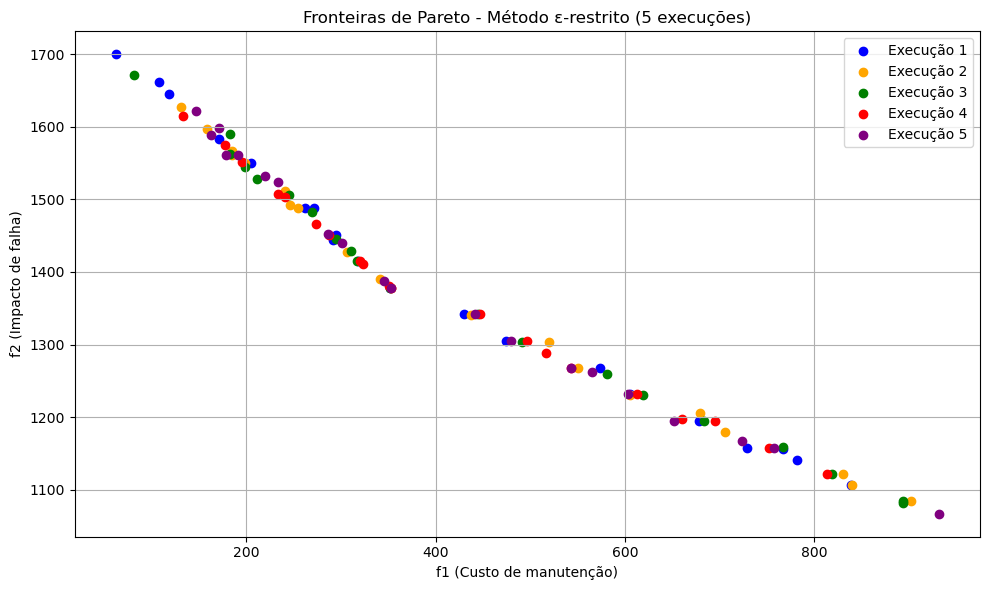

In [15]:
plt.figure(figsize=(10, 6))
cores = ['blue', 'orange', 'green', 'red', 'purple']

for i in range(n_execucoes):
    plt.scatter(todas_f1[i], todas_f2[i], color=cores[i], label=f'Execução {i+1}')

plt.xlabel("f1 (Custo de manutenção)")
plt.ylabel("f2 (Impacto de falha)")
plt.title("Fronteiras de Pareto - Método ε-restrito (5 execuções)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
from deap.tools._hypervolume import hv as calc_hipervolume
import numpy as np

# Junta todas as soluções das 5 execuções
pontos = []
for f1s, f2s in zip(todas_f1, todas_f2):
    for f1, f2 in zip(f1s, f2s):
        pontos.append([abs(f1), abs(f2)])

pontos = np.array(pontos)

# Vetor de referência (anti-utópico ideal)
referencia = [1000, 1745.49]

# Calcula o hipervolume corretamente
hipervol = calc_hipervolume(pontos, referencia)

print(f"Hipervolume total: {hipervol:.2f}")


NameError: name 'todas_f1' is not defined